In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [4]:
train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSewr,SalePrice
0,1059,0,0,3,773.0,0.0,1.0,0.0,286.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,142500.0
1,2492,0,0,2,2146.0,0.0,1.0,0.0,346.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,552000.0
2,1008,0,0,2,643.0,0.0,1.0,0.0,365.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,134500.0
3,1214,0,0,2,0.0,0.0,0.0,0.0,1214.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,179781.0
4,832,384,0,2,442.0,0.0,0.0,0.0,390.0,102,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,118500.0


In [5]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    alg.fit(dtrain[predictors], dtrain['SalePrice'])
    
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['SalePrice'], cv=cv_folds, scoring='mean_squared_error')
        
    print("\nModel Report")
    print("Mean squared error: {0}".format(metrics.mean_squared_error(dtrain['SalePrice'].values, dtrain_predictions)))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)[0:40]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Baseline Model


Model Report
Mean squared error: 202586659.79665503
CV Score : Mean - -5.603484e+08 | Std - 1.200454e+08 | Min - -7.285508e+08 | Max - -3.796305e+08


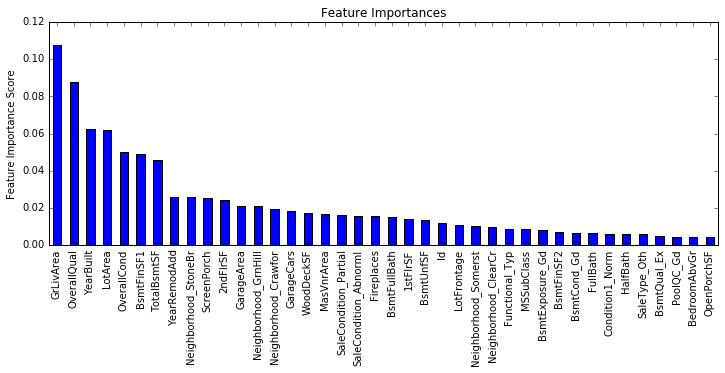

In [6]:
predictors = [x for x in train.columns if x not in ['SalePrice']]
gbm0 = GradientBoostingRegressor(random_state=10)

modelfit(gbm0, train, test, predictors)

In [37]:
gbm0.get_params()

{'alpha': 0.9,
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 10,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

### Step 1- Find the number of estimators for a high learning rate

In [54]:
param_test1 = { 'n_estimators': list(range(500,1000,10)) }

In [55]:
gsearch1 = GridSearchCV(
    estimator = GradientBoostingRegressor(
        learning_rate=0.120, 
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=8,
        max_features='sqrt',
        subsample=1,
        presort= 'auto',
        random_state=10),
    param_grid = param_test1, 
    scoring='mean_squared_error',
    n_jobs=4,
    iid=False, 
    cv=5
)

gsearch1.fit(train[predictors], train['SalePrice'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.12, loss='ls',
             max_depth=8, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=1, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [56]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -612469574.76411, std: 113535330.05661, params: {'n_estimators': 500},
  mean: -612470440.27992, std: 113536610.62947, params: {'n_estimators': 510},
  mean: -612470910.01918, std: 113537357.42868, params: {'n_estimators': 520},
  mean: -612470655.31966, std: 113539655.68480, params: {'n_estimators': 530},
  mean: -612468419.47254, std: 113541738.89496, params: {'n_estimators': 540},
  mean: -612467820.81947, std: 113541428.85896, params: {'n_estimators': 550},
  mean: -612467215.02114, std: 113542588.95895, params: {'n_estimators': 560},
  mean: -612467110.21505, std: 113543405.74840, params: {'n_estimators': 570},
  mean: -612467918.36748, std: 113543318.75118, params: {'n_estimators': 580},
  mean: -612467556.36733, std: 113543157.00649, params: {'n_estimators': 590},
  mean: -612467456.64544, std: 113543450.32387, params: {'n_estimators': 600},
  mean: -612467459.34377, std: 113543893.73098, params: {'n_estimators': 610},
  mean: -612467684.24254, std: 113544371.36789, para

### Step 2- Tune tree-specific parameters

In [74]:
param_test2 = {
    'max_depth': list(range(5,20,2)),
    'min_samples_split': list(range(2,50,5))
}

gsearch2 = GridSearchCV(
    estimator = GradientBoostingRegressor(
        learning_rate=0.120,
        n_estimators=660,
        max_features='sqrt',
        subsample=1,
        random_state=10),
    param_grid = param_test2, 
    scoring='mean_squared_error',
    n_jobs=4,
    iid=False, 
    cv=5
)

gsearch2.fit(train[predictors], train['SalePrice'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.12, loss='ls',
             max_depth=3, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=660,
             presort='auto', random_state=10, subsample=1, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [5, 7, 9, 11, 13, 15, 17, 19], 'min_samples_split': [2, 7, 12, 17, 22, 27, 32, 37, 42, 47]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [75]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -521877452.99885, std: 73189309.31126, params: {'max_depth': 5, 'min_samples_split': 2},
  mean: -542997989.02945, std: 92292548.47541, params: {'max_depth': 5, 'min_samples_split': 7},
  mean: -537409113.53290, std: 81154155.60585, params: {'max_depth': 5, 'min_samples_split': 12},
  mean: -551742335.41901, std: 77052611.71539, params: {'max_depth': 5, 'min_samples_split': 17},
  mean: -528867135.60800, std: 87265163.18550, params: {'max_depth': 5, 'min_samples_split': 22},
  mean: -535248990.50313, std: 71558943.44471, params: {'max_depth': 5, 'min_samples_split': 27},
  mean: -514619688.49559, std: 73081632.77470, params: {'max_depth': 5, 'min_samples_split': 32},
  mean: -525847575.42993, std: 81226104.62737, params: {'max_depth': 5, 'min_samples_split': 37},
  mean: -540125006.72341, std: 95715343.68868, params: {'max_depth': 5, 'min_samples_split': 42},
  mean: -526408945.59864, std: 81052908.70497, params: {'max_depth': 5, 'min_samples_split': 47},
  mean: -635730566.957

In [76]:
param_test3 = {
    'min_samples_split': list(range(200,1001,200)),
    'min_samples_leaf':list(range(30,71,10))
}
gsearch3 = GridSearchCV(
    estimator = GradientBoostingRegressor(
        learning_rate=0.120,
        n_estimators=660,
        max_depth=5,
        presort='auto',
        min_weight_fraction_leaf=0.0,
        min_samples_split=32,
        min_samples_leaf=1,
        subsample=0.8, 
        random_state=10), 
    param_grid = param_test3, 
    scoring='mean_squared_error',
    n_jobs=4,
    iid=False, 
    cv=5)
gsearch3.fit(train[predictors],train['SalePrice'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.12, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=32,
             min_weight_fraction_leaf=0.0, n_estimators=660,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000], 'min_samples_leaf': [30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [78]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -613329439.60709, std: 107389440.27568, params: {'min_samples_split': 200, 'min_samples_leaf': 30},
  mean: -585832423.01047, std: 101556521.79034, params: {'min_samples_split': 400, 'min_samples_leaf': 30},
  mean: -600169706.70006, std: 99955567.87121, params: {'min_samples_split': 600, 'min_samples_leaf': 30},
  mean: -597579142.38885, std: 108920567.68057, params: {'min_samples_split': 800, 'min_samples_leaf': 30},
  mean: -592036671.19945, std: 88729996.00248, params: {'min_samples_split': 1000, 'min_samples_leaf': 30},
  mean: -600107018.61996, std: 106448690.25492, params: {'min_samples_split': 200, 'min_samples_leaf': 40},
  mean: -599164835.62211, std: 95160488.07480, params: {'min_samples_split': 400, 'min_samples_leaf': 40},
  mean: -599921960.98691, std: 108420761.75532, params: {'min_samples_split': 600, 'min_samples_leaf': 40},
  mean: -607217218.51742, std: 101419809.39600, params: {'min_samples_split': 800, 'min_samples_leaf': 40},
  mean: -603571611.67696, std:


Model Report
Mean squared error: 300281232.6073574
CV Score : Mean - -7.756669e+08 | Std - 2.451849e+08 | Min - -1.062079e+09 | Max - -4.471266e+08


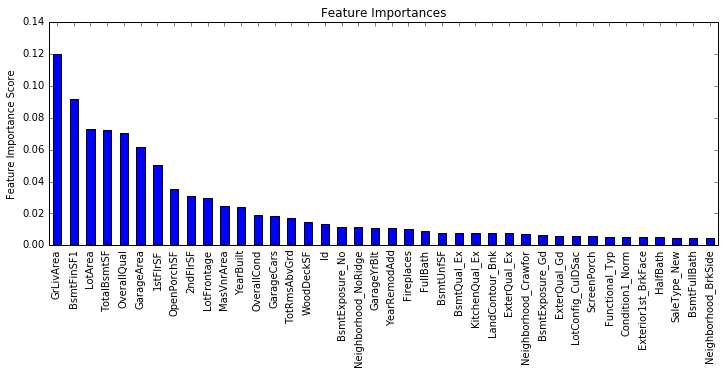

In [14]:
modelfit(gsearch3.best_estimator_, train, test, predictors)

In [15]:
param_test4 = {
    'max_features': list(range(7,20,2))
}
gsearch4 = GridSearchCV(
    estimator = GradientBoostingRegressor(
        learning_rate=0.2,
        n_estimators=170,
        max_depth=5,
        min_samples_split=800,
        min_samples_leaf=30,
        subsample=0.8, 
        random_state=10), 
    param_grid = param_test4, 
    scoring='mean_squared_error',
    n_jobs=4,
    iid=False, 
    cv=5)
gsearch4.fit(train[predictors],train['SalePrice'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.2, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=30, min_samples_split=800,
             min_weight_fraction_leaf=0.0, n_estimators=170,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [16]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -960676125.27505, std: 305044485.79112, params: {'max_features': 7},
  mean: -894706484.11021, std: 299708659.86779, params: {'max_features': 9},
  mean: -896336290.82571, std: 296861217.05011, params: {'max_features': 11},
  mean: -867239794.66973, std: 281293961.71319, params: {'max_features': 13},
  mean: -865209755.14277, std: 271261260.16914, params: {'max_features': 15},
  mean: -889250210.97462, std: 280709456.29564, params: {'max_features': 17},
  mean: -866296714.78759, std: 281185988.11016, params: {'max_features': 19}],
 {'max_features': 15},
 -865209755.14277112)

### Step 3- Tune subsample and lower learning rate

In [17]:
#Grid seach on subsample and max_features
param_test5 = {
    'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
}

gsearch5 = GridSearchCV(
    estimator = GradientBoostingRegressor(
        learning_rate=0.2,
        n_estimators=170,
        max_depth=5,
        min_samples_split=800,
        min_samples_leaf=30,
        subsample=0.8, 
        random_state=10,
        max_features=15), 
    param_grid = param_test5, 
    scoring='mean_squared_error',
    n_jobs=4,
    iid=False, 
    cv=5)

gsearch5.fit(train[predictors],train['SalePrice'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.2, loss='ls',
             max_depth=5, max_features=15, max_leaf_nodes=None,
             min_samples_leaf=30, min_samples_split=800,
             min_weight_fraction_leaf=0.0, n_estimators=170,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [71]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -6313386366.15251, std: 870733182.67080, params: {'subsample': 0.6},
  mean: -955180482.54138, std: 314413911.39801, params: {'subsample': 0.7},
  mean: -882870717.84723, std: 278825437.41931, params: {'subsample': 0.75},
  mean: -865209755.14277, std: 271261260.16914, params: {'subsample': 0.8},
  mean: -839817708.37915, std: 245658051.63443, params: {'subsample': 0.85},
  mean: -845825875.88659, std: 286326094.46334, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 -839817708.37915397)


Model Report
Mean squared error: 386252361.7701038
CV Score : Mean - -6.488795e+08 | Std - 1.035413e+08 | Min - -7.63639e+08 | Max - -4.806394e+08


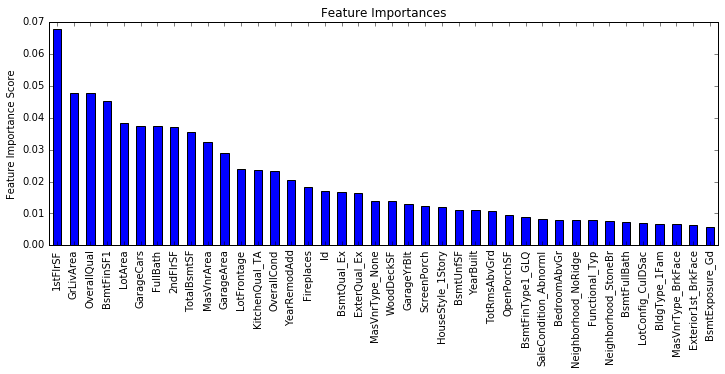

In [73]:
gbm_tuned_1 = GradientBoostingRegressor(
        learning_rate=0.2,
        n_estimators=170,
        max_depth=5,
        min_samples_split=800,
        min_samples_leaf=30,
        subsample=0.85, 
        random_state=10,
        max_features=15)

modelfit(gbm_tuned_1, train, test, predictors)


Model Report
Mean squared error: 384983348.8908997
CV Score : Mean - -8.727651e+08 | Std - 2.362334e+08 | Min - -1.228551e+09 | Max - -6.071201e+08


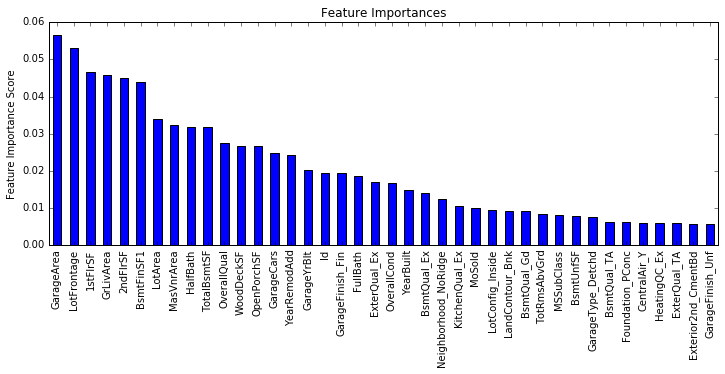

In [20]:
gbm_tuned_2 = GradientBoostingRegressor(
        learning_rate=0.5,
        n_estimators=170,
        max_depth=5,
        min_samples_split=800,
        min_samples_leaf=30,
        subsample=0.85, 
        random_state=10,
        max_features=15)

modelfit(gbm_tuned_2, train, test, predictors)


Model Report
Mean squared error: 29.64685251817522
CV Score : Mean - -6.656784e+08 | Std - 1.528153e+08 | Min - -9.199519e+08 | Max - -4.537286e+08


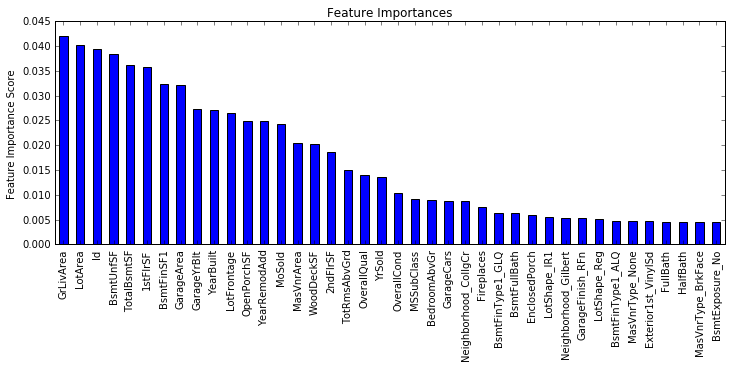

In [7]:
gbm_tuned_3 = GradientBoostingRegressor(
        learning_rate=0.120,
        n_estimators=660,
        max_depth=8,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.85, 
        random_state=10,
        max_features=15)

modelfit(gbm_tuned_3, train, test, predictors)

In [8]:
preds = gbm_tuned_3.predict(test[predictors])
gbm_tuned_3.get_params()

{'alpha': 0.9,
 'init': None,
 'learning_rate': 0.12,
 'loss': 'ls',
 'max_depth': 8,
 'max_features': 15,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 660,
 'presort': 'auto',
 'random_state': 10,
 'subsample': 0.85,
 'verbose': 0,
 'warm_start': False}

In [9]:
preds

array([ 108487.98756523,  167512.63524582,  196444.12511982, ...,
        129734.99432079,  111551.79475925,  189708.55439752])

In [10]:
df_preds = pd.DataFrame(preds, index=test["Id"], columns=["SalePrice"])
df_preds.to_csv('output.csv', header=True, index_label='Id')